In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
%cd /content/drive/MyDrive/Colab Notebooks/DIA-CompanionChatbot/SVM

/content/drive/MyDrive/Colab Notebooks/DIA-CompanionChatbot/SVM


In [62]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from textblob import Word
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [51]:
df = pd.read_csv('emotion_data.csv')
# df = df.dropna(axis=0, subset=['Emotion'])

In [52]:
df['Emotion'] = df['Emotion'].replace([0, 1, 2, 3, 4], ['Neutral', 'Happy', 'Sad', 'Love', 'Anger'])


In [53]:
df['Emotion'].value_counts()

Sad        16251
Happy      15444
Neutral     9643
Love        8248
Anger       6188
Name: Emotion, dtype: int64

In [54]:
df.isna().sum()

Text       90
Emotion     0
dtype: int64

In [55]:
df = df.dropna()

In [56]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
# stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [58]:
# Removing Punctuation, Symbols
df['Text'] = df['Text'].str.replace('[^\w\s]',' ')

# Removing Stop Words using NLTK
stop = stopwords.words('english')
df['Text']= df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Lemmatisation
df['Text'] = df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#Correcting Letter Repetitions

def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

df['Text'] = df['Text'].apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

# Code to find the top 10,000 rarest words appearing in the data
freq = pd.Series(' '.join(df['Text']).split()).value_counts()[-2000:]

# Removing all those rarely appearing words from the data
freq = list(freq.index)
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

<ipython-input-58-670e811c4678>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]',' ')


In [59]:
#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df['Emotion'])

In [60]:
# Splitting into training and testing data in 90:10 ratio
X_train, X_val, y_train, y_val = train_test_split(df['Text'], y, stratify=y, random_state=42, test_size=0.1, shuffle=True)


In [81]:
# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(df['Text'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

In [82]:
# Model 2: Linear SVM - figure out accuracy later, check if proba works
lsvm = SGDClassifier(alpha=0.001, random_state=5, tol=None)
lsvm_calibrated = CalibratedClassifierCV(lsvm)
lsvm_calibrated.fit(X_train_count, y_train)


CalibratedClassifierCV(estimator=SGDClassifier(alpha=0.001, random_state=5,
                                               tol=None))

In [83]:
y_pred = lsvm_calibrated.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))

lsvm using count vectors accuracy 0.568863350691327


In [12]:
import pickle

In [22]:
#0 - Anger, 1 - Happy, 2 - Love, 3 - Neutral, 4 - Sad

In [13]:
# with open("SVMCountVectorizer", 'wb') as fout:
#     pickle.dump((lsvm_calibrated, count_vect), fout)

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from textblob import Word

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\94773\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\94773\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
with open('SVMCountVectorizer', 'rb') as f:
    svm_model, vectorizer = pickle.load(f)

NameError: name 'pickle' is not defined

In [ ]:
svm_model 

In [16]:
to_test = "Success is right around the corner. Lets celebrate this victory"

In [17]:
to_test = to_test.replace('[^\w\s]',' ')
to_test = ' '.join([word for word in to_test.split() if word not in stop])
to_test = " ".join([Word(word).lemmatize() for word in to_test.split()])

In [18]:
# Extracting Count Vectors feature from our tweets
tweet_count = vectorizer.transform([to_test])

In [19]:
tweet_count

<1x30685 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [24]:
pred = svm_model.predict_proba(tweet_count)

In [66]:
emotion_scores = {
    "anger": 0,
    "happy": 0,
    "love": 0,
    "neutral": 0,
    "sad": 0
}

In [73]:
classes = ["anger", "happy", "love", "neutral", "sad"]

In [67]:
print(emotion_scores)

{'anger': 0, 'happy': 0, 'love': 0, 'neutral': 0, 'sad': 0}


In [69]:
pred[0]

array([0.03498243, 0.54653028, 0.08010654, 0.16164571, 0.17673505])

In [70]:
emotion_scores['anger'] += pred[0][0]
emotion_scores['happy'] += pred[0][1]
emotion_scores['love'] += pred[0][2]
emotion_scores['neutral'] += pred[0][3]
emotion_scores['sad'] += pred[0][4]

In [71]:
print(emotion_scores)

{'anger': 0.034982430501194185, 'happy': 0.5465302762851102, 'love': 0.08010653755654662, 'neutral': 0.1616457070510107, 'sad': 0.17673504860613826}


In [78]:
highest_score = max(pred[0])
prediction_list = list(pred[0])
indexOfMaxEmotion = prediction_list.index(highest_score)
classes[indexOfMaxEmotion]

'happy'

In [1]:
#Testing the model on 50, handpicked messages

In [90]:
import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from textblob import Word

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\94773\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\94773\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
with open('SVMCountVectorizer', 'rb') as f:
    svm_model, vectorizer = pickle.load(f)

In [92]:
import pandas as pd

df = pd.read_csv("Handpicked.csv")

In [93]:
#0 - Anger, 1 - Happy, 2 - Love, 3 - Neutral, 4 - Sad

In [94]:
df.head()

,Text,Emotion,EmotionSVMLOGREG
0,"I don't feel like doing anything today, everyt...",sad,4
1,I just found out my grandmother passed away an...,sad,4
2,"I feel so alone and isolated, like no one unde...",sad,4
3,"I can't believe I lost my job, how am I going ...",sad,4
4,"I miss my ex so much, it's hard to move on.",sad,4


In [95]:
actual_emotion = df['EmotionSVMLOGREG']

In [96]:
to_test = df['Text']

In [97]:
len(to_test)

50

In [98]:
def toCountVectors(text):
    text = text.replace('[^\w\s]',' ')
    text = ' '.join([word for word in text.split() if word not in stop])
    text = " ".join([Word(word).lemmatize() for word in text.split()])
    print(text)
#     tweet_count = vectorizer.transform([text])
    return text

In [99]:
inputData = []

for i in range(len(to_test)):
    CV = toCountVectors(to_test[i])
    inputData.append(CV)

I feel like anything today, everything seems pointless.
I found grandmother passed away I can't stop crying.
I feel alone isolated, like one understands me.
I can't believe I lost job, I going pay bills?
I miss ex much, hard move on.
I'm struggling depression hard find motivation get bed.
I feel like I'm constantly disappointing everyone around me.
I received bad news doctor I'm feeling really down.
I'm heartbroken, pet passed away.
I feel like I'm stuck rut I know break free.
I can't believe me, I'm furious!
I'm sick tired dealing nonsense, I'm snap.
Why everything difficult? I'm getting really angry.
I feel disrespected undervalued, making angry.
I can't stand unfair situation is, making really angry.
I'm angry letting thing get far.
I'm lose temper keep happening.
I can't believe audacity say me, I'm angry.
I'm frustrated situation, making see red.
I'm going stand anymore, I'm feeling really angry fed up.
I'm looking forward trying new restaurant town.
I meeting 2 pm tomorrow, I nee

In [100]:
len(inputData)

50

In [101]:
countVectorizers = vectorizer.transform(inputData)

In [102]:
countVectorizers

<50x30685 sparse matrix of type '<class 'numpy.int64'>'
	with 282 stored elements in Compressed Sparse Row format>

In [103]:
pred = svm_model.predict(countVectorizers)

In [104]:
#0 - Anger, 1 - Happy, 2 - Love, 3 - Neutral, 4 - Sad
pred

array([4, 3, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 0, 0, 0, 0, 4, 0, 1, 0, 4, 4,
       1, 4, 4, 4, 3, 1, 1, 4, 2, 2, 3, 3, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1,
       1, 1, 2, 1, 2, 1], dtype=int64)

In [121]:
from sklearn.metrics import classification_report
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [112]:
print(classification_report(actual_emotion, pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.50      0.60      0.55        10
           2       0.78      0.70      0.74        10
           3       0.25      0.10      0.14        10
           4       0.42      0.80      0.55        10

    accuracy                           0.56        50
   macro avg       0.59      0.56      0.55        50
weighted avg       0.59      0.56      0.55        50



In [124]:
x = confusion_matrix(actual_emotion, pred)

In [125]:
classes = ["Anger", "Happy", "Love", "Neutral", "Sad"]

<AxesSubplot:>

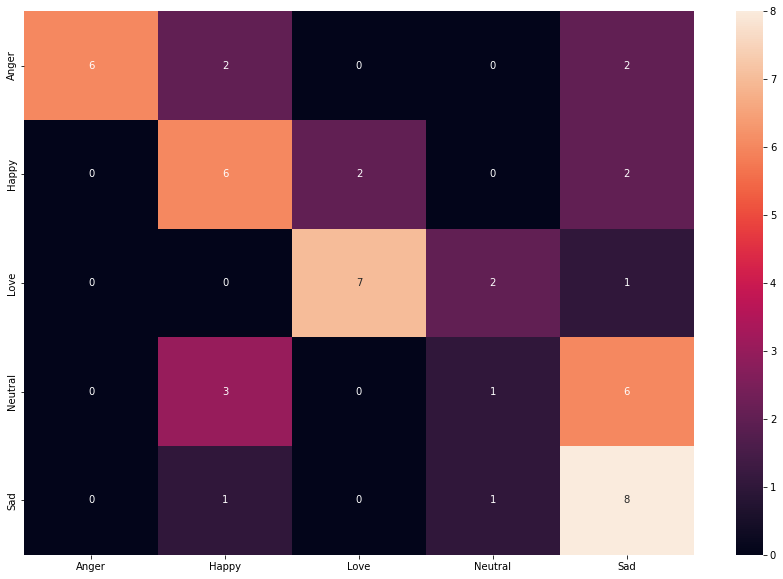

In [129]:
df_cm = pd.DataFrame(x, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (15,10))

sn.heatmap(df_cm, annot=True)

In [55]:
#Testing the model on 8 different messages

In [2]:
import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from textblob import Word

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\94773\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\94773\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
with open('SVMCountVectorizer2.0', 'rb') as f:
    svm_model, vectorizer = pickle.load(f)

In [52]:
text = "im happy to meet my parents soon!"

In [53]:
text = text.replace('[^\w\s]',' ')
text = ' '.join([word for word in text.split() if word not in stop])
text = " ".join([Word(word).lemmatize() for word in text.split()])
print(text)
countVectorizers = vectorizer.transform([text])
pred = svm_model.predict_proba(countVectorizers)
#0 - Anger, 1 - Happy, 2 - Love, 3 - Neutral, 4 - Sad

im happy meet parent soon!


In [54]:
print(pred)
# print(pred)

[[0.05777645 0.33746911 0.13745779 0.22297029 0.24432636]]
